# Gather

In [2]:
import numpy as np
import pandas as pd
import requests
import tweepy
import json
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# WeRateDogs Twitter archive
df_tw_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Get Tweet image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)
    
df_tw_img_preds = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
# Get data from Twitter API
consumer_key = <consumer_key>
consumer_secret = <consumer_secret>
access_token = <access_token>
access_secret = <access_secret>

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

tweet_list = df_tw_archive['tweet_id']
count = 0

for tweet in tweet_list:
    count += 1
    print(f"time: {time.time()}, count: {count}, tweet: {tweet}")
    
    try:
        tweet = api.get_status(tweet, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    
        temp_dict = {
            'id': tweet._json['id'],
            'retweet_count': tweet._json['retweet_count'],
            'favorite_count': tweet._json['favorite_count']
        }

        with open('tweet_json.txt', 'a') as outfile:
            json.dump(temp_dict, outfile)
            outfile.write('\n')
    except tweepy.TweepError as twe:
        print(f"tweet ID {tweet} call failed with error: {twe}")

time: 1606294818.0156915, count: 1, tweet: 892420643555336193
time: 1606294818.2283418, count: 2, tweet: 892177421306343426
time: 1606294818.3899486, count: 3, tweet: 891815181378084864
time: 1606294818.5877402, count: 4, tweet: 891689557279858688
time: 1606294818.7455041, count: 5, tweet: 891327558926688256
time: 1606294818.9597511, count: 6, tweet: 891087950875897856
time: 1606294819.1178188, count: 7, tweet: 890971913173991426
time: 1606294819.307844, count: 8, tweet: 890729181411237888
time: 1606294819.4606478, count: 9, tweet: 890609185150312448
time: 1606294819.643797, count: 10, tweet: 890240255349198849
time: 1606294819.8431401, count: 11, tweet: 890006608113172480
time: 1606294820.0084999, count: 12, tweet: 889880896479866881
time: 1606294820.170443, count: 13, tweet: 889665388333682689
time: 1606294820.378538, count: 14, tweet: 889638837579907072
time: 1606294820.5347688, count: 15, tweet: 889531135344209921
time: 1606294820.7513418, count: 16, tweet: 889278841981685760
time:

time: 1606294839.8490312, count: 123, tweet: 869227993411051520
time: 1606294840.0592816, count: 124, tweet: 868880397819494401
time: 1606294840.2171063, count: 125, tweet: 868639477480148993
time: 1606294840.4135227, count: 126, tweet: 868622495443632128
time: 1606294840.595923, count: 127, tweet: 868552278524837888
time: 1606294840.7568474, count: 128, tweet: 867900495410671616
time: 1606294840.9771998, count: 129, tweet: 867774946302451713
time: 1606294841.1850634, count: 130, tweet: 867421006826221569
time: 1606294841.3462071, count: 131, tweet: 867072653475098625
time: 1606294841.5912733, count: 132, tweet: 867051520902168576
time: 1606294841.7495277, count: 133, tweet: 866816280283807744
tweet ID 866816280283807744 call failed with error: [{'code': 144, 'message': 'No status found with that ID.'}]
time: 1606294841.925636, count: 134, tweet: 866720684873056260
time: 1606294842.1480355, count: 135, tweet: 866686824827068416
time: 1606294842.3289523, count: 136, tweet: 8664507055314

time: 1606294862.0089848, count: 245, tweet: 846042936437604353
time: 1606294862.2358077, count: 246, tweet: 845812042753855489
time: 1606294862.4319904, count: 247, tweet: 845677943972139009
time: 1606294862.6163557, count: 248, tweet: 845459076796616705
tweet ID 845459076796616705 call failed with error: [{'code': 144, 'message': 'No status found with that ID.'}]
time: 1606294862.7994342, count: 249, tweet: 845397057150107648
time: 1606294862.9904418, count: 250, tweet: 845306882940190720
time: 1606294863.206025, count: 251, tweet: 845098359547420673
time: 1606294863.3719544, count: 252, tweet: 844979544864018432
time: 1606294863.5970654, count: 253, tweet: 844973813909606400
time: 1606294863.7916212, count: 254, tweet: 844704788403113984
tweet ID 844704788403113984 call failed with error: [{'code': 144, 'message': 'No status found with that ID.'}]
time: 1606294863.988761, count: 255, tweet: 844580511645339650
time: 1606294864.1432476, count: 256, tweet: 844223788422217728
time: 1606

time: 1606294883.913525, count: 366, tweet: 829011960981237760
time: 1606294884.1270843, count: 367, tweet: 828801551087042563
time: 1606294884.3509781, count: 368, tweet: 828770345708580865
time: 1606294884.5375168, count: 369, tweet: 828708714936930305
time: 1606294884.6920278, count: 370, tweet: 828650029636317184
time: 1606294884.8472736, count: 371, tweet: 828409743546925057
time: 1606294885.0494044, count: 372, tweet: 828408677031882754
time: 1606294885.2583275, count: 373, tweet: 828381636999917570
time: 1606294885.4172096, count: 374, tweet: 828376505180889089
time: 1606294885.60603, count: 375, tweet: 828372645993398273
time: 1606294885.7955823, count: 376, tweet: 828361771580813312
time: 1606294886.0605679, count: 377, tweet: 828046555563323392
time: 1606294886.2213974, count: 378, tweet: 828011680017821696
time: 1606294886.3847384, count: 379, tweet: 827933404142436356
time: 1606294886.5364704, count: 380, tweet: 827653905312006145
time: 1606294886.7545962, count: 381, tweet

time: 1606294907.5857008, count: 493, tweet: 813217897535406080
time: 1606294907.7732966, count: 494, tweet: 813202720496779264
time: 1606294907.940332, count: 495, tweet: 813187593374461952
time: 1606294908.1401105, count: 496, tweet: 813172488309972993
time: 1606294908.357106, count: 497, tweet: 813157409116065792
time: 1606294908.5245194, count: 498, tweet: 813142292504645637
time: 1606294908.7136312, count: 499, tweet: 813130366689148928
time: 1606294908.900396, count: 500, tweet: 813127251579564032
time: 1606294909.060052, count: 501, tweet: 813112105746448384
time: 1606294909.2193606, count: 502, tweet: 813096984823349248
time: 1606294909.4180806, count: 503, tweet: 813081950185472002
time: 1606294909.5991373, count: 504, tweet: 813066809284972545
time: 1606294909.7848055, count: 505, tweet: 813051746834595840
time: 1606294909.9435594, count: 506, tweet: 812781120811126785
time: 1606294910.142391, count: 507, tweet: 812747805718642688
tweet ID 812747805718642688 call failed with 

time: 1606294930.8270473, count: 620, tweet: 796149749086875649
time: 1606294931.0359087, count: 621, tweet: 796125600683540480
time: 1606294931.2344632, count: 622, tweet: 796116448414461957
time: 1606294931.39034, count: 623, tweet: 796080075804475393
time: 1606294931.5773993, count: 624, tweet: 796031486298386433
time: 1606294931.794184, count: 625, tweet: 795464331001561088
time: 1606294932.0074246, count: 626, tweet: 795400264262053889
time: 1606294932.1697097, count: 627, tweet: 795076730285391872
time: 1606294932.4176676, count: 628, tweet: 794983741416415232
time: 1606294932.6433096, count: 629, tweet: 794926597468000259
time: 1606294932.8022935, count: 630, tweet: 794355576146903043
time: 1606294933.0023508, count: 631, tweet: 794332329137291264
time: 1606294933.1640267, count: 632, tweet: 794205286408003585
time: 1606294933.3645315, count: 633, tweet: 793962221541933056
time: 1606294933.5765333, count: 634, tweet: 793845145112371200
time: 1606294933.7717605, count: 635, tweet

time: 1606295508.9444325, count: 749, tweet: 779377524342161408
time: 1606295509.1105275, count: 750, tweet: 779124354206535695
time: 1606295509.3608985, count: 751, tweet: 779123168116150273
tweet ID 779123168116150273 call failed with error: [{'code': 144, 'message': 'No status found with that ID.'}]
time: 1606295509.5017886, count: 752, tweet: 779056095788752897
time: 1606295509.6884086, count: 753, tweet: 778990705243029504
time: 1606295509.839475, count: 754, tweet: 778774459159379968
time: 1606295510.0037851, count: 755, tweet: 778764940568104960
time: 1606295510.188318, count: 756, tweet: 778748913645780993
time: 1606295510.3674173, count: 757, tweet: 778650543019483137
time: 1606295510.5259113, count: 758, tweet: 778624900596654080
time: 1606295510.7105994, count: 759, tweet: 778408200802557953
time: 1606295510.9012177, count: 760, tweet: 778396591732486144
time: 1606295511.059563, count: 761, tweet: 778383385161035776
time: 1606295511.2214344, count: 762, tweet: 77828681018739

time: 1606295531.3021808, count: 872, tweet: 761599872357261312
time: 1606295531.4859362, count: 873, tweet: 761371037149827077
time: 1606295531.6814883, count: 874, tweet: 761334018830917632
time: 1606295531.866535, count: 875, tweet: 761292947749015552
time: 1606295532.0256982, count: 876, tweet: 761227390836215808
time: 1606295532.1795669, count: 877, tweet: 761004547850530816
time: 1606295532.341463, count: 878, tweet: 760893934457552897
time: 1606295532.5326488, count: 879, tweet: 760656994973933572
time: 1606295532.72929, count: 880, tweet: 760641137271070720
time: 1606295532.8865361, count: 881, tweet: 760539183865880579
time: 1606295533.0425434, count: 882, tweet: 760521673607086080
time: 1606295533.3171833, count: 883, tweet: 760290219849637889
time: 1606295533.499574, count: 884, tweet: 760252756032651264
time: 1606295533.6575394, count: 885, tweet: 760190180481531904
time: 1606295533.8127275, count: 886, tweet: 760153949710192640
time: 1606295533.9801123, count: 887, tweet: 

time: 1606295553.9377027, count: 997, tweet: 748337862848962560
time: 1606295554.147064, count: 998, tweet: 748324050481647620
time: 1606295554.3340213, count: 999, tweet: 748307329658011649
time: 1606295554.5234623, count: 1000, tweet: 748220828303695873
time: 1606295554.673905, count: 1001, tweet: 747963614829678593
time: 1606295554.8392227, count: 1002, tweet: 747933425676525569
time: 1606295554.991924, count: 1003, tweet: 747885874273214464
time: 1606295555.1864731, count: 1004, tweet: 747844099428986880
time: 1606295555.3406155, count: 1005, tweet: 747816857231626240
time: 1606295555.5078669, count: 1006, tweet: 747651430853525504
time: 1606295555.6981018, count: 1007, tweet: 747648653817413632
time: 1606295555.8521454, count: 1008, tweet: 747600769478692864
time: 1606295556.049524, count: 1009, tweet: 747594051852075008
time: 1606295556.2116144, count: 1010, tweet: 747512671126323200
time: 1606295556.366199, count: 1011, tweet: 747461612269887489
time: 1606295556.5692885, count: 

time: 1606295576.874423, count: 1125, tweet: 730211855403241472
time: 1606295577.0550742, count: 1126, tweet: 730196704625098752
time: 1606295577.272148, count: 1127, tweet: 729854734790754305
time: 1606295577.4334326, count: 1128, tweet: 729838605770891264
time: 1606295577.6461875, count: 1129, tweet: 729823566028484608
time: 1606295577.836462, count: 1130, tweet: 729463711119904772
time: 1606295577.9978278, count: 1131, tweet: 729113531270991872
time: 1606295578.1620092, count: 1132, tweet: 728986383096946689
time: 1606295578.3224826, count: 1133, tweet: 728760639972315136
time: 1606295578.4702773, count: 1134, tweet: 728751179681943552
time: 1606295578.6384573, count: 1135, tweet: 728653952833728512
time: 1606295578.8492916, count: 1136, tweet: 728409960103686147
time: 1606295579.0421185, count: 1137, tweet: 728387165835677696
time: 1606295579.2271364, count: 1138, tweet: 728046963732717569
time: 1606295579.3809645, count: 1139, tweet: 728035342121635841
time: 1606295579.573718, cou

time: 1606295599.910658, count: 1253, tweet: 710844581445812225
time: 1606295600.0742104, count: 1254, tweet: 710833117892898816
time: 1606295600.2651129, count: 1255, tweet: 710658690886586372
time: 1606295600.4656827, count: 1256, tweet: 710609963652087808
time: 1606295600.6520824, count: 1257, tweet: 710588934686908417
time: 1606295600.862747, count: 1258, tweet: 710296729921429505
time: 1606295601.0226636, count: 1259, tweet: 710283270106132480
time: 1606295601.2319982, count: 1260, tweet: 710272297844797440
time: 1606295601.431328, count: 1261, tweet: 710269109699739648
time: 1606295601.6749775, count: 1262, tweet: 710153181850935296
time: 1606295601.8888934, count: 1263, tweet: 710140971284037632
time: 1606295602.0866852, count: 1264, tweet: 710117014656950272
time: 1606295602.2503026, count: 1265, tweet: 709918798883774466
time: 1606295602.4627504, count: 1266, tweet: 709901256215666688
time: 1606295602.6281562, count: 1267, tweet: 709852847387627521
time: 1606295602.8071413, co

time: 1606295623.7221532, count: 1381, tweet: 701214700881756160
time: 1606295623.9438376, count: 1382, tweet: 700890391244103680
time: 1606295624.1045976, count: 1383, tweet: 700864154249383937
time: 1606295624.2709296, count: 1384, tweet: 700847567345688576
time: 1606295624.4847784, count: 1385, tweet: 700796979434098688
time: 1606295624.6461544, count: 1386, tweet: 700747788515020802
time: 1606295624.8305888, count: 1387, tweet: 700518061187723268
time: 1606295625.0554063, count: 1388, tweet: 700505138482569216
time: 1606295625.2297368, count: 1389, tweet: 700462010979500032
time: 1606295625.4211571, count: 1390, tweet: 700167517596164096
time: 1606295625.6301808, count: 1391, tweet: 700151421916807169
time: 1606295625.8416767, count: 1392, tweet: 700143752053182464
time: 1606295626.0217154, count: 1393, tweet: 700062718104104960
time: 1606295626.1867182, count: 1394, tweet: 700029284593901568
time: 1606295626.338134, count: 1395, tweet: 700002074055016451
time: 1606295626.5497327, 

time: 1606295646.8259676, count: 1509, tweet: 691483041324204033
time: 1606295647.0069869, count: 1510, tweet: 691459709405118465
time: 1606295647.17065, count: 1511, tweet: 691444869282295808
time: 1606295647.3541205, count: 1512, tweet: 691416866452082688
time: 1606295647.5200367, count: 1513, tweet: 691321916024623104
time: 1606295647.677326, count: 1514, tweet: 691096613310316544
time: 1606295647.8711743, count: 1515, tweet: 691090071332753408
time: 1606295648.0534613, count: 1516, tweet: 690989312272396288
time: 1606295648.2110634, count: 1517, tweet: 690959652130045952
time: 1606295648.3641016, count: 1518, tweet: 690938899477221376
time: 1606295648.578214, count: 1519, tweet: 690932576555528194
time: 1606295648.7389352, count: 1520, tweet: 690735892932222976
time: 1606295648.9231803, count: 1521, tweet: 690728923253055490
time: 1606295649.0778713, count: 1522, tweet: 690690673629138944
time: 1606295649.2668355, count: 1523, tweet: 690649993829576704
time: 1606295649.4760623, cou

time: 1606296411.9819698, count: 1636, tweet: 684222868335505415
time: 1606296412.1889727, count: 1637, tweet: 684200372118904832
time: 1606296412.3501701, count: 1638, tweet: 684195085588783105
time: 1606296412.5356476, count: 1639, tweet: 684188786104872960
time: 1606296412.7039819, count: 1640, tweet: 684177701129875456
time: 1606296412.904092, count: 1641, tweet: 684147889187209216
time: 1606296413.0898001, count: 1642, tweet: 684122891630342144
time: 1606296413.2544377, count: 1643, tweet: 684097758874210310
time: 1606296413.4498398, count: 1644, tweet: 683857920510050305
time: 1606296413.6553886, count: 1645, tweet: 683852578183077888
time: 1606296413.8475742, count: 1646, tweet: 683849932751646720
time: 1606296414.0372868, count: 1647, tweet: 683834909291606017
time: 1606296414.197939, count: 1648, tweet: 683828599284170753
time: 1606296414.3816755, count: 1649, tweet: 683773439333797890
time: 1606296414.5321503, count: 1650, tweet: 683742671509258241
time: 1606296414.7120078, c

time: 1606296434.4763203, count: 1761, tweet: 678708137298427904
time: 1606296434.6991081, count: 1762, tweet: 678675843183484930
time: 1606296434.9070902, count: 1763, tweet: 678643457146150913
time: 1606296435.1015027, count: 1764, tweet: 678446151570427904
time: 1606296435.301617, count: 1765, tweet: 678424312106393600
time: 1606296435.5082655, count: 1766, tweet: 678410210315247616
time: 1606296435.6978748, count: 1767, tweet: 678399652199309312
time: 1606296435.9138927, count: 1768, tweet: 678396796259975168
time: 1606296436.1280007, count: 1769, tweet: 678389028614488064
time: 1606296436.32078, count: 1770, tweet: 678380236862578688
time: 1606296436.5150173, count: 1771, tweet: 678341075375947776
time: 1606296436.6817453, count: 1772, tweet: 678334497360859136
time: 1606296436.8758855, count: 1773, tweet: 678278586130948096
time: 1606296437.0391805, count: 1774, tweet: 678255464182861824
time: 1606296437.2222705, count: 1775, tweet: 678023323247357953
time: 1606296437.434987, cou

time: 1606296457.6821623, count: 1888, tweet: 674788554665512960
time: 1606296457.8944044, count: 1889, tweet: 674781762103414784
time: 1606296458.1050744, count: 1890, tweet: 674774481756377088
time: 1606296458.2998793, count: 1891, tweet: 674767892831932416
time: 1606296458.4535394, count: 1892, tweet: 674764817387900928
time: 1606296458.6106715, count: 1893, tweet: 674754018082705410
time: 1606296458.805815, count: 1894, tweet: 674752233200820224
time: 1606296459.0265799, count: 1895, tweet: 674743008475090944
time: 1606296459.2200463, count: 1896, tweet: 674742531037511680
time: 1606296459.3786442, count: 1897, tweet: 674739953134403584
time: 1606296459.6035516, count: 1898, tweet: 674737130913071104
time: 1606296459.7940283, count: 1899, tweet: 674690135443775488
time: 1606296459.969204, count: 1900, tweet: 674670581682434048
time: 1606296460.1835482, count: 1901, tweet: 674664755118911488
time: 1606296460.338491, count: 1902, tweet: 674646392044941312
time: 1606296460.52975, coun

time: 1606296480.5725164, count: 2015, tweet: 672222792075620352
time: 1606296480.7628803, count: 2016, tweet: 672205392827572224
time: 1606296480.9120834, count: 2017, tweet: 672169685991993344
time: 1606296481.0984843, count: 2018, tweet: 672160042234327040
time: 1606296481.283543, count: 2019, tweet: 672139350159835138
time: 1606296481.4984267, count: 2020, tweet: 672125275208069120
time: 1606296481.6809595, count: 2021, tweet: 672095186491711488
time: 1606296481.8620496, count: 2022, tweet: 672082170312290304
time: 1606296482.0518098, count: 2023, tweet: 672068090318987265
time: 1606296482.2191799, count: 2024, tweet: 671896809300709376
time: 1606296482.3888319, count: 2025, tweet: 671891728106971137
time: 1606296482.573977, count: 2026, tweet: 671882082306625538
time: 1606296482.7372835, count: 2027, tweet: 671879137494245376
time: 1606296482.9029853, count: 2028, tweet: 671874878652489728
time: 1606296483.0578506, count: 2029, tweet: 671866342182637568
time: 1606296483.2405586, c

time: 1606296503.6937873, count: 2142, tweet: 669993076832759809
time: 1606296503.8574195, count: 2143, tweet: 669972011175813120
time: 1606296504.0138357, count: 2144, tweet: 669970042633789440
time: 1606296504.1770768, count: 2145, tweet: 669942763794931712
time: 1606296504.3392637, count: 2146, tweet: 669926384437997569
time: 1606296504.4981146, count: 2147, tweet: 669923323644657664
time: 1606296504.6906374, count: 2148, tweet: 669753178989142016
time: 1606296504.879628, count: 2149, tweet: 669749430875258880
time: 1606296505.0339959, count: 2150, tweet: 669684865554620416
time: 1606296505.2257087, count: 2151, tweet: 669683899023405056
time: 1606296505.3804727, count: 2152, tweet: 669682095984410625
time: 1606296505.6019175, count: 2153, tweet: 669680153564442624
time: 1606296505.7898562, count: 2154, tweet: 669661792646373376
time: 1606296505.9955778, count: 2155, tweet: 669625907762618368
time: 1606296506.1503932, count: 2156, tweet: 669603084620980224
time: 1606296506.3148851, 

time: 1606296526.810217, count: 2270, tweet: 667509364010450944
time: 1606296526.9690878, count: 2271, tweet: 667502640335572993
time: 1606296527.1826353, count: 2272, tweet: 667495797102141441
time: 1606296527.336444, count: 2273, tweet: 667491009379606528
time: 1606296527.544024, count: 2274, tweet: 667470559035432960
time: 1606296527.7021515, count: 2275, tweet: 667455448082227200
time: 1606296527.9384286, count: 2276, tweet: 667453023279554560
time: 1606296528.1003528, count: 2277, tweet: 667443425659232256
time: 1606296528.3037004, count: 2278, tweet: 667437278097252352
time: 1606296528.4614701, count: 2279, tweet: 667435689202614272
time: 1606296528.6176178, count: 2280, tweet: 667405339315146752
time: 1606296528.7801735, count: 2281, tweet: 667393430834667520
time: 1606296528.9776373, count: 2282, tweet: 667369227918143488
time: 1606296529.203395, count: 2283, tweet: 667211855547486208
time: 1606296529.359828, count: 2284, tweet: 667200525029539841
time: 1606296529.5190616, coun

In [5]:
with open('tweet_json.txt', 'r') as file:
    lines = file.readlines()
    
    list_tw_api = list()
    
    for line in lines:
        data = json.loads(line)
        temp_dict = {
            'id': data['id'],
            'retweet_count': data['retweet_count'],
            'favorite_count': data['favorite_count']
        }
        list_tw_api.append(temp_dict)
        
df_tw_api = pd.DataFrame(list_tw_api)

# Assess

In [6]:
# Assess WeRateDogs Twitter archive
df_tw_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
df_tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
print(df_tw_archive['floofer'].value_counts())
print(df_tw_archive['pupper'].value_counts())
print(df_tw_archive['puppo'].value_counts())
print(df_tw_archive['doggo'].value_counts())

None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64
None     2259
doggo      97
Name: doggo, dtype: int64


In [23]:
df_tw_archive[df_tw_archive['retweeted_status_id'].notna() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [7]:
df_tw_archive[df_tw_archive['in_reply_to_status_id'].notna() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [11]:
df_tw_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [21]:
df_tw_archive[df_tw_archive['rating_numerator'] >= 15]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
285,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KibaDva: I collected all the good dogs!! 1...,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,https://twitter.com/KibaDva/status/83890598062...,15,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@bragg6of8 @Andy_Pace_ we are still looking fo...,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None


In [22]:
df_tw_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [32]:
df_tw_archive.query('rating_denominator == 2')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [9]:
# Assess Tweet image predictions
df_tw_img_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
df_tw_img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
df_tw_img_preds['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [9]:
df_tw_img_preds.groupby(['p1', 'p1_dog'])['tweet_id'].count().sort_values(ascending=False)

p1                         p1_dog
golden_retriever           True      150
Labrador_retriever         True      100
Pembroke                   True       89
Chihuahua                  True       83
pug                        True       57
chow                       True       44
Samoyed                    True       43
toy_poodle                 True       39
Pomeranian                 True       38
malamute                   True       30
cocker_spaniel             True       30
French_bulldog             True       26
miniature_pinscher         True       23
Chesapeake_Bay_retriever   True       23
seat_belt                  False      22
Siberian_husky             True       20
Staffordshire_bullterrier  True       20
German_shepherd            True       20
Cardigan                   True       19
web_site                   False      19
Shetland_sheepdog          True       18
Eskimo_dog                 True       18
beagle                     True       18
Maltese_dog            

In [12]:
df_tw_img_preds.groupby(['p2', 'p2_dog'])['tweet_id'].count().sort_values(ascending=False)

p2                              p2_dog
Labrador_retriever              True      104
golden_retriever                True       92
Cardigan                        True       73
Chihuahua                       True       44
Pomeranian                      True       42
French_bulldog                  True       41
Chesapeake_Bay_retriever        True       41
toy_poodle                      True       37
cocker_spaniel                  True       34
Siberian_husky                  True       33
miniature_poodle                True       33
beagle                          True       28
collie                          True       27
Pembroke                        True       27
Eskimo_dog                      True       27
kuvasz                          True       26
Italian_greyhound               True       22
American_Staffordshire_terrier  True       21
Pekinese                        True       21
Samoyed                         True       20
toy_terrier                     True     

In [13]:
df_tw_img_preds.groupby(['p3', 'p3_dog'])['tweet_id'].count().sort_values(ascending=False)

p3                              p3_dog
Labrador_retriever              True      79
Chihuahua                       True      58
golden_retriever                True      48
Eskimo_dog                      True      38
kelpie                          True      35
kuvasz                          True      34
Staffordshire_bullterrier       True      32
chow                            True      32
cocker_spaniel                  True      31
beagle                          True      31
Pekinese                        True      29
Pomeranian                      True      29
toy_poodle                      True      29
Chesapeake_Bay_retriever        True      27
Pembroke                        True      27
Great_Pyrenees                  True      27
malamute                        True      26
French_bulldog                  True      26
American_Staffordshire_terrier  True      24
Cardigan                        True      23
pug                             True      23
basenji         

In [10]:
# Assess Twitter API data
df_tw_api.head()

,favorite_count,id,retweet_count
0,35388,892420643555336193,7472
1,30631,892177421306343426,5545
2,23039,891815181378084864,3670
3,38679,891689557279858688,7647
4,36962,891327558926688256,8248


In [11]:
df_tw_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2331 non-null int64
id                2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


## Quality

### WeRateDogs Twitter archive (df_tw_archive)
1. Statuses where retweeted_status_id or in_reply_to_status_id are not null, are not original ratings.
2. Timestamp column should be datetime data type. Also, data in floofer column should be boolean data type.
3. When the status has other numbers separated by slashes, these are incorrectly captured as the rating. Tweet ID's where this happened: 740373189193256964, 682962037429899265, 666287406224695296, 810984652412424192.
4. When the status uses a float for the rating, the rating_numerator is captured incorrectly. Tweet ID's where this happened: 778027034220126208, 680494726643068929, 786709082849828864.
5. Tweets with a rating_denominator greater than 10 are for statuses with multiple dogs.

### Tweet image predictions (df_tw_img_preds)
6. img_num column should be category data type.
7. If p1_dog, p2_dog, or p3_dog are False, the predicted dog breed is invalid for our analysis.
8. p1, p2, and p3 columns have inconsistent capitalization.

## Tidiness

### WeRateDogs Twitter archive (df_tw_archive)
Pupper, puppo, and doggo info in separate columns.

### Twitter API data (df_tw_api)
The data in df_tw_api should be in df_tw_archive.

### Image predictions (df_tw_img_preds)
The data in df_tw_img_preds should also be in df_tw_archive.

# Clean

In [6]:
df_tw_archive_clean = df_tw_archive.copy()
df_tw_img_preds_clean = df_tw_img_preds.copy()
df_tw_api_clean = df_tw_api.copy()

## Tidiness

### WeRateDogs Twitter archive - pupper/puppo/doggo columns
#### Define
Add a new column called dog_stage, which will list whether the dog is a doggo/puppo/pupper. If a dog doesn't have any of these stages, set dog_stage to 'other.'

#### Code

In [7]:
# The approach below was chosen over the melt method. Melt resulted in extra rows, as some dogs were classified as a doggo and either puppo or pupper.
# Combine the contents of doggo, pupper, and puppo, then remove the None part. This is dog_stage.
df_tw_archive_clean['dog_stage'] = df_tw_archive_clean['doggo'] + ", " + df_tw_archive_clean['pupper'] + ", " + df_tw_archive_clean['puppo']
df_tw_archive_clean['dog_stage'] = df_tw_archive_clean['dog_stage'].str.replace('None, ', '')
df_tw_archive_clean['dog_stage'] = df_tw_archive_clean['dog_stage'].str.replace(', None', '')
df_tw_archive_clean.loc[df_tw_archive_clean['dog_stage'] == 'None', 'dog_stage'] = 'other'
df_tw_archive_clean.drop(['doggo', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [8]:
df_tw_archive_clean['dog_stage'].value_counts()

other            1985
pupper            245
doggo              84
puppo              29
doggo, pupper      12
doggo, puppo        1
Name: dog_stage, dtype: int64

In [9]:
# Confirm same number of rows as the original df_tw_archive dataframe
df_tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
floofer                       2356 non-null object
dog_stage                     2356 non-null object
dtypes: float64(4), int64(3), object(8)
memory usage: 276.2+ KB


### Twitter API data - Should be in original Twitter archive data set
#### Define
1. Join df_twitter_api_clean to df_tw_archive_clean
2. Drop the id column
3. Cast favorite_count and retweet_count as int again

#### Code

In [10]:
df_tw_archive_api = df_tw_archive_clean.merge(df_tw_api_clean, left_on='tweet_id', right_on='id', how='left')

df_tw_archive_api.drop(['id'], axis=1, inplace=True)

df_tw_archive_api.loc[df_tw_archive_api['favorite_count'].isnull(), 'favorite_count'] = 0
df_tw_archive_api.loc[df_tw_archive_api['retweet_count'].isnull(), 'retweet_count'] = 0

df_tw_archive_api['favorite_count'] = df_tw_archive_api['favorite_count'].astype(int)
df_tw_archive_api['retweet_count'] = df_tw_archive_api['retweet_count'].astype(int)

#### Test

In [11]:
df_tw_archive_api.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
floofer                       2356 non-null object
dog_stage                     2356 non-null object
favorite_count                2356 non-null int64
retweet_count                 2356 non-null int64
dtypes: float64(4), int64(5), obje

### Image prediciton data - Should be in the same dataframe as original Twitter archive and API data.
#### Define
Join df_tw_img_preds_clean to df_tw_archive_api

#### Code

In [12]:
df_tw_complete = df_tw_archive_api.merge(df_tw_img_preds_clean, left_on='tweet_id', right_on='tweet_id', how='left')

#### Test

In [13]:
df_tw_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
floofer                       2356 non-null object
dog_stage                     2356 non-null object
favorite_count                2356 non-null int64
retweet_count                 2356 non-null int64
jpg_url                       2075

## Quality
### Statuses where retweeted_status_id or in_reply_to_status_id are not null, are not original ratings
#### Define
Remove rows that have a retweeted_status_id or in_reply_to_status_id

#### Code

In [14]:
df_tw_complete = df_tw_complete[df_tw_complete['retweeted_status_id'].notna() == False]
df_tw_complete = df_tw_complete[df_tw_complete['in_reply_to_status_id'].notna() == False]

#### Test

In [15]:
df_tw_complete[df_tw_complete['retweeted_status_id'].notna() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [16]:
df_tw_complete[df_tw_complete['in_reply_to_status_id'].notna() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [17]:
df_tw_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
floofer                       2097 non-null object
dog_stage                     2097 non-null object
favorite_count                2097 non-null int64
retweet_count                 2097 non-null int64
jpg_url                       1971 non-nul

### timestamp column should be datetime data type
#### Define
Use the to_datetime method to change the data type

#### Code

In [18]:
df_tw_complete['timestamp'] = pd.to_datetime(df_tw_complete['timestamp'])

#### Test

In [19]:
df_tw_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
floofer                       2097 non-null object
dog_stage                     2097 non-null object
favorite_count                2097 non-null int64
retweet_count                 2097 non-null int64
jpg_url                       1971

In [20]:
df_tw_complete.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Data in floofer column should be boolean data type
#### Define
Create a new column called is_floofer. Set the value to True if the dog is a floofer. Otherwise set it False.

#### Code

In [21]:
df_tw_complete.loc[df_tw_complete['floofer'] == 'floofer', 'is_floofer'] = True
df_tw_complete.loc[df_tw_complete['floofer'] == 'None', 'is_floofer'] = False

#### Test

In [22]:
df_tw_complete.query('is_floofer == True')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_floofer
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,...,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True,True
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,...,English_springer,0.354733,True,collie,0.177538,True,Border_collie,0.131706,True,True
582,800388270626521089,NaN,NaN,2016-11-20 17:20:08,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800388270...,...,golden_retriever,0.359860,True,Pembroke,0.194207,True,collie,0.154603,True,True
774,776218204058357768,NaN,NaN,2016-09-15 00:36:55,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776218204...,...,Samoyed,0.940326,True,Pomeranian,0.055527,True,keeshond,0.002226,True,True
984,749317047558017024,NaN,NaN,2016-07-02 19:01:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Blu. He's a wild bush Floofer. I wish ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749317047...,...,wire-haired_fox_terrier,0.155144,True,Lakeland_terrier,0.108382,True,buckeye,0.074617,False,True
1022,746542875601690625,NaN,NaN,2016-06-25 03:17:46,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a golden floofer helping with the groce...,NaN,NaN,NaN,https://vine.co/v/5uZYwqmuDeT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1091,737445876994609152,NaN,NaN,2016-05-31 00:49:32,"<a href=""http://twitter.com/download/iphone"" r...",Just wanted to share this super rare Rainbow F...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737445876...,...,Samoyed,0.400568,True,Pomeranian,0.331268,True,Maltese_dog,0.045426,True,True
1110,733822306246479872,NaN,NaN,2016-05-21 00:50:46,"<a href=""http://twitter.com/download/iphone"" r...",This is Moose. He's a Polynesian Floofer. Dapp...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/733822306...,...,Lhasa,0.457356,True,Shih-Tzu,0.371282,True,Tibetan_terrier,0.048359,True,True
1534,689993469801164801,NaN,NaN,2016-01-21 02:10:37,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a rare High Stepping Al...,NaN,NaN,NaN,https://vine.co/v/ienexVMZgi5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1614,685307451701334016,NaN,NaN,2016-01-08 03:50:03,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Petrick. He's an Altostratus Floo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685307451...,...,Pomeranian,0.963176,True,Shetland_sheepdog,0.019468,True,keeshond,0.008605,True,True


In [23]:
df_tw_complete.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_floofer
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,False
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,False
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,False


### When the status has other numbers separated by slashes, these are incorrectly captured as the rating
#### Define
1. Manually correct the rating for these tweet ID's: 740373189193256964, 682962037429899265, 666287406224695296
2. Remove tweet ID 810984652412424192, as it does not have a rating

#### Code

In [24]:
df_tw_complete.loc[df_tw_complete['tweet_id'] == 740373189193256964, 'rating_numerator'] = 14
df_tw_complete.loc[df_tw_complete['tweet_id'] == 682962037429899265, 'rating_numerator'] = 10
df_tw_complete.loc[df_tw_complete['tweet_id'] == 666287406224695296, 'rating_numerator'] = 9
df_tw_complete.loc[df_tw_complete['tweet_id'] == 666287406224695296, 'rating_denominator'] = 10

In [25]:
df_tw_complete = df_tw_complete.query('tweet_id != 810984652412424192')

#### Test

In [26]:
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 740373189193256964, 'rating_numerator'])
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 682962037429899265, 'rating_numerator'])
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 666287406224695296, 'rating_numerator'])
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 666287406224695296, 'rating_denominator'])

1068    14
Name: rating_numerator, dtype: int64
1662    10
Name: rating_numerator, dtype: int64
2335    9
Name: rating_numerator, dtype: int64
2335    10
Name: rating_denominator, dtype: int64


In [27]:
df_tw_complete.query('tweet_id == 810984652412424192')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_floofer


### When the status uses a float for the rating, the rating_numerator is captured incorrectly
#### Define
Manually correct the rating for these tweet ID's: 778027034220126208, 680494726643068929, 786709082849828864.

#### Code

In [28]:
df_tw_complete.loc[df_tw_complete['tweet_id'] == 778027034220126208, 'rating_numerator'] = 11
df_tw_complete.loc[df_tw_complete['tweet_id'] == 680494726643068929, 'rating_numerator'] = 11
df_tw_complete.loc[df_tw_complete['tweet_id'] == 786709082849828864, 'rating_numerator'] = 10

#### Test

In [29]:
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 778027034220126208, 'rating_numerator'])
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 680494726643068929, 'rating_numerator'])
print(df_tw_complete.loc[df_tw_complete['tweet_id'] == 786709082849828864, 'rating_numerator'])

763    11
Name: rating_numerator, dtype: int64
1712    11
Name: rating_numerator, dtype: int64
695    10
Name: rating_numerator, dtype: int64


### Tweets with a rating_denominator greater than 10 are for statuses with multiple dogs
#### Define
Remove tweet ID's where rating_denominator is greater than 10.

#### Code

In [30]:
df_tw_complete = df_tw_complete.query('rating_denominator <= 10')

#### Test

In [31]:
df_tw_complete['rating_denominator'].value_counts()

10    2081
Name: rating_denominator, dtype: int64

### img_num column should be category data type
#### Define
Use pandas astype method to change data type

#### Code

In [32]:
df_tw_complete['img_num'] = df_tw_complete['img_num'].astype('category')

#### Test

In [33]:
df_tw_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                      2081 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2081 non-null datetime64[ns]
source                        2081 non-null object
text                          2081 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2078 non-null object
rating_numerator              2081 non-null int64
rating_denominator            2081 non-null int64
name                          2081 non-null object
floofer                       2081 non-null object
dog_stage                     2081 non-null object
favorite_count                2081 non-null int64
retweet_count                 2081 non-null int64
jpg_url                       1955

### If p1_dog, p2_dog, or p3_dog are False, the predicted dog breed is invalid for our analysis.
#### Define
Filter on rows with invalid dog breed names. Replace the breed name with NaN.

#### Code

In [34]:
df_tw_complete.loc[df_tw_complete['p1_dog'] == False, 'p1'] = np.nan
df_tw_complete.loc[df_tw_complete['p2_dog'] == False, 'p2'] = np.nan
df_tw_complete.loc[df_tw_complete['p3_dog'] == False, 'p3'] = np.nan

#### Test

In [35]:
df_tw_complete.query('p1_dog == False')['p1']

0       NaN
3       NaN
22      NaN
28      NaN
52      NaN
57      NaN
58      NaN
67      NaN
69      NaN
105     NaN
112     NaN
117     NaN
123     NaN
141     NaN
144     NaN
153     NaN
157     NaN
163     NaN
164     NaN
169     NaN
170     NaN
203     NaN
208     NaN
209     NaN
210     NaN
214     NaN
215     NaN
219     NaN
224     NaN
225     NaN
       ... 
2242    NaN
2246    NaN
2247    NaN
2248    NaN
2251    NaN
2254    NaN
2256    NaN
2258    NaN
2261    NaN
2267    NaN
2276    NaN
2277    NaN
2281    NaN
2285    NaN
2299    NaN
2302    NaN
2303    NaN
2304    NaN
2305    NaN
2310    NaN
2312    NaN
2322    NaN
2326    NaN
2330    NaN
2333    NaN
2334    NaN
2337    NaN
2338    NaN
2347    NaN
2349    NaN
Name: p1, Length: 505, dtype: object

In [36]:
df_tw_complete.query('p2_dog == False')['p2']

0       NaN
22      NaN
24      NaN
28      NaN
31      NaN
52      NaN
56      NaN
57      NaN
58      NaN
61      NaN
69      NaN
111     NaN
112     NaN
117     NaN
141     NaN
144     NaN
153     NaN
157     NaN
163     NaN
164     NaN
170     NaN
183     NaN
203     NaN
208     NaN
209     NaN
214     NaN
215     NaN
223     NaN
224     NaN
225     NaN
       ... 
2240    NaN
2242    NaN
2247    NaN
2248    NaN
2250    NaN
2254    NaN
2256    NaN
2258    NaN
2261    NaN
2267    NaN
2271    NaN
2272    NaN
2276    NaN
2277    NaN
2281    NaN
2285    NaN
2299    NaN
2302    NaN
2304    NaN
2305    NaN
2307    NaN
2310    NaN
2321    NaN
2326    NaN
2330    NaN
2334    NaN
2337    NaN
2338    NaN
2347    NaN
2349    NaN
Name: p2, Length: 489, dtype: object

In [37]:
df_tw_complete.query('p3_dog == False')['p3']

0       NaN
3       NaN
5       NaN
6       NaN
11      NaN
22      NaN
26      NaN
28      NaN
31      NaN
48      NaN
53      NaN
56      NaN
57      NaN
58      NaN
65      NaN
69      NaN
79      NaN
87      NaN
108     NaN
111     NaN
112     NaN
117     NaN
121     NaN
123     NaN
141     NaN
144     NaN
153     NaN
158     NaN
163     NaN
164     NaN
       ... 
2248    NaN
2254    NaN
2255    NaN
2256    NaN
2258    NaN
2261    NaN
2262    NaN
2271    NaN
2272    NaN
2276    NaN
2277    NaN
2281    NaN
2285    NaN
2299    NaN
2301    NaN
2302    NaN
2303    NaN
2304    NaN
2305    NaN
2306    NaN
2310    NaN
2321    NaN
2322    NaN
2326    NaN
2330    NaN
2334    NaN
2337    NaN
2338    NaN
2348    NaN
2349    NaN
Name: p3, Length: 537, dtype: object

### p1, p2, and p3 columns have inconsistent capitalization
#### Define
Replace underscores with spaces, then user pandas str.title method to capitalize the first word in the p1, p2, and p3 columns.

#### Code

In [38]:
df_tw_complete['p1'] = df_tw_complete['p1'].str.replace('_', ' ', regex=False)
df_tw_complete['p1'] = df_tw_complete['p1'].str.title()

df_tw_complete['p2'] = df_tw_complete['p2'].str.replace('_', ' ', regex=False)
df_tw_complete['p2'] = df_tw_complete['p2'].str.title()

df_tw_complete['p3'] = df_tw_complete['p3'].str.replace('_', ' ', regex=False)
df_tw_complete['p3'] = df_tw_complete['p3'].str.title()

#### Test

In [39]:
df_tw_complete['p1'].value_counts()

Golden Retriever              134
Labrador Retriever             91
Pembroke                       88
Chihuahua                      78
Pug                            54
Chow                           41
Samoyed                        40
Pomeranian                     38
Toy Poodle                     37
Malamute                       29
Cocker Spaniel                 27
French Bulldog                 26
Chesapeake Bay Retriever       23
Miniature Pinscher             21
German Shepherd                20
Siberian Husky                 19
Staffordshire Bullterrier      19
Maltese Dog                    18
Shetland Sheepdog              18
Eskimo Dog                     18
Beagle                         17
Cardigan                       17
Shih-Tzu                       17
Rottweiler                     16
Italian Greyhound              16
Kuvasz                         15
Lakeland Terrier               15
Pekinese                       13
Basset                         13
Vizsla        

In [40]:
df_tw_complete['p2'].value_counts()

Labrador Retriever                95
Golden Retriever                  80
Cardigan                          72
Chihuahua                         41
Chesapeake Bay Retriever          40
French Bulldog                    39
Pomeranian                        38
Toy Poodle                        36
Siberian Husky                    33
Miniature Poodle                  32
Cocker Spaniel                    30
Eskimo Dog                        27
Beagle                            27
Collie                            26
Pembroke                          24
Italian Greyhound                 22
Pekinese                          21
Kuvasz                            21
American Staffordshire Terrier    20
Chow                              20
Miniature Pinscher                20
Malinois                          20
Boston Bull                       19
Toy Terrier                       19
Norwegian Elkhound                19
Pug                               17
Samoyed                           17
S

In [41]:
df_tw_complete['p3'].value_counts()

Labrador Retriever                74
Chihuahua                         57
Golden Retriever                  44
Eskimo Dog                        35
Kelpie                            33
Kuvasz                            31
Staffordshire Bullterrier         30
Beagle                            29
Cocker Spaniel                    29
Toy Poodle                        29
Chow                              29
Pekinese                          28
Pomeranian                        27
Pembroke                          26
Malamute                          25
Great Pyrenees                    25
French Bulldog                    25
Chesapeake Bay Retriever          24
Cardigan                          23
American Staffordshire Terrier    22
Pug                               20
Basenji                           20
Siberian Husky                    19
Bull Mastiff                      19
Toy Terrier                       18
Boston Bull                       17
Lakeland Terrier                  16
B

# Store

In [98]:
df_tw_complete.to_csv('twitter_archive_master.csv', index=False)

# Analyze

In [42]:
df_tw_complete.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)
df_tw_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2081 non-null int64
timestamp             2081 non-null datetime64[ns]
source                2081 non-null object
text                  2081 non-null object
expanded_urls         2078 non-null object
rating_numerator      2081 non-null int64
rating_denominator    2081 non-null int64
name                  2081 non-null object
floofer               2081 non-null object
dog_stage             2081 non-null object
favorite_count        2081 non-null int64
retweet_count         2081 non-null int64
jpg_url               1955 non-null object
img_num               1955 non-null category
p1                    1450 non-null object
p1_conf               1955 non-null float64
p1_dog                1955 non-null object
p2                    1466 non-null object
p2_conf               1955 non-null float64
p2_dog                1955 non-null object
p3                    1418

In [43]:
df_tw_complete['rating_numerator'].value_counts()

12      486
10      437
11      415
13      287
9       153
8        98
7        51
14       38
5        34
6        32
3        19
4        15
2         9
1         4
420       1
1776      1
0         1
Name: rating_numerator, dtype: int64

In [44]:
df_tw_complete = df_tw_complete.query('rating_numerator > 0')
df_tw_complete = df_tw_complete.query('rating_numerator < 420')
df_tw_complete['rating_numerator'].value_counts()

12    486
10    437
11    415
13    287
9     153
8      98
7      51
14     38
5      34
6      32
3      19
4      15
2       9
1       4
Name: rating_numerator, dtype: int64

In [45]:
df_tw_complete['intercept'] = 1

dog_stage_dummies = pd.get_dummies(df_tw_complete['dog_stage'])
df_tw_complete_dummies = df_tw_complete.join(dog_stage_dummies)
df_tw_complete_dummies.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,dog_stage,...,p3_conf,p3_dog,is_floofer,intercept,doggo,"doggo, pupper","doggo, puppo",other,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,other,...,0.076110,False,False,1,0,0,0,1,0,0
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,other,...,0.068957,True,False,1,0,0,0,1,0,0
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,other,...,0.031379,True,False,1,0,0,0,1,0,0
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,other,...,0.040836,False,False,1,0,0,0,1,0,0
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,other,...,0.175219,True,False,1,0,0,0,1,0,0


In [46]:
lm = sm.OLS(df_tw_complete_dummies['favorite_count'], df_tw_complete_dummies[['intercept', 'doggo', 'doggo, pupper', 'doggo, puppo', 'other', 'pupper', 'puppo']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     16.69
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           3.43e-16
Time:                        10:20:47   Log-Likelihood:                -22403.
No. Observations:                2078   AIC:                         4.482e+04
Df Residuals:                    2072   BIC:                         4.485e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.542e+04   1803.669      8.548      0.000    1.19e+04     1.9e+04
doggo          1465.2895   2140.680      0.684      0.494   -2732.818    5663.397
doggo, pupper -2776.2112   3746.361     -0.741      0.459   -1.01e+04    4570.813
doggo, puppo    2.82e+04      1e+04      2.816      0.005    8563.715    4.78e+04
other         -7661.2251   1818.967     -4.212      0.000   -1.12e+04   -4094.031
pupper        -8867.1036   1921.538     -4.615      0.000   -1.26e+04   -5098.757
puppo          5053.5617   2733.545      1.849      0.065    -307.219    1.04e+04
==============================================================================
Omnibus:                     1891.827   Durbin-Watson:                   1.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79519.586
Skew:                           4.232   Prob(JB):                         0.00
Kurtosis:                      32.099   Cond. No.                     1.66e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Insight 1
p_values are low for 'doggo, puppo', 'other', 'pupper', and 'puppo', so some dog stages do appear to affect the favorite_count. However, r-squared is very low, so a linear model is not a good fit for our data.

In [47]:
df_tw_complete.groupby(by='is_floofer')['rating_numerator', 'favorite_count', 'retweet_count'].mean()

,rating_numerator,favorite_count,retweet_count
is_floofer,,,
False,10.604932,8116.792553,2430.65764
True,11.800000,10434.200000,3480.30000


In [48]:
df_tw_complete.groupby(by='is_floofer')['rating_numerator', 'favorite_count', 'retweet_count'].std()

,rating_numerator,favorite_count,retweet_count
is_floofer,,,
False,2.142508,11885.851435,4285.849418
True,1.032796,9167.558572,4444.508373


## Insight 2
Floofers have similar rating_numerator as non-floofers. It is less clear whether floofers have different favorite_count or retweet_count as non-floofers, as the standard deviation for these metrics is the same order of magnitude as the mean.

In [49]:
df_tw_complete = df_tw_complete.dropna(subset=['p1_conf'])
df_tw_complete['p1_conf'].isna().sum()

0

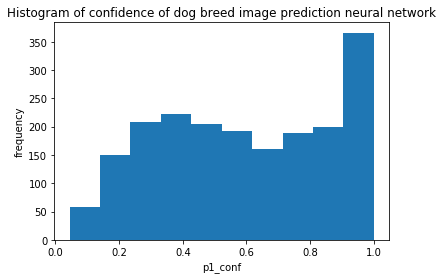

In [50]:
plt.hist(df_tw_complete['p1_conf'], bins=10)
plt.xlabel('p1_conf')
plt.ylabel('frequency')
plt.title('Histogram of confidence of dog breed image prediction neural network')
plt.show()

## Visualization Note
The histogram shows that the dog breed image prediction neural network had varying degrees of confidence. The bin with highest confidence also had highest frequency, which is great to see.

In [51]:
df_tw_complete.query('p1_conf >= 0.95').groupby('p1')['p1'].count().sort_values(ascending=False).head(10)

p1
Pug                   20
Pembroke              19
Samoyed               19
Golden Retriever      16
Pomeranian            13
Chihuahua              9
Labrador Retriever     8
French Bulldog         8
Chow                   7
German Shepherd        4
Name: p1, dtype: int64

## Insight 3
Dog breeds where the image prediction neural network most frequently had high confidence were pug, samoyed, pembroke, and golden retriever.